After creating the scraper tool last notebook, import it here and try to identify what signals I might want to use for modelling. 

In [3]:
import sys
sys.path.append('../dat/')

from collect_and_prepare_data import collect_data

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
coin_df = collect_data(prior_years=0,prior_days=90,crypto='bitcoin',values='usd')

2021-08-11T10:01:24.000000000
2021-08-11T11:00:43.000000000


In [41]:
approx_resolution= (coin_df['timestamp'].diff() / 1000).dropna().mean()
approx_resolution

86400.0

In [26]:
(coin_df['timestamp'].diff() / 1000).dropna().std()

306.3984213237975

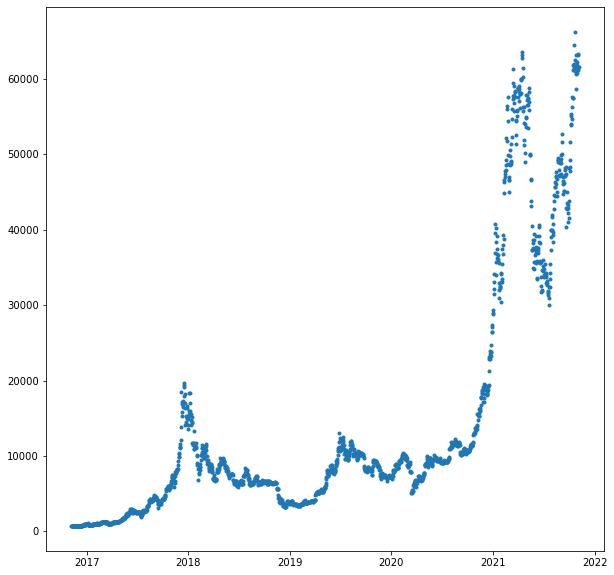

In [11]:
plt.figure(figsize = (10,10))
plt.plot(coin_df['date'],coin_df['bitcoin_price'], '.')

Naive idea: I'm not an attentive trader, and am only interested in scenarios where I can be like "omg wow I got rich quick". 

Does such a situation exist? Not really. But if it did, the signal I would be most interested in is ones where the price of BTC jumpts by over x% compared to what it's average was over the prior week. 

To get such signals, what I can do is compute the weekly rolling mean value of price, and side by side of these columns calculate the % difference of today's price compared to the weekly avg. 

In [18]:
coin_df['moving_avg'] = coin_df['bitcoin_price'].rolling(window=7).mean().shift(1) # for day i, computes the window rolling average for the prior i-1 to i-1-window days. 

In [24]:
coin_df['pct_change'] =  100*(coin_df['bitcoin_price'] - coin_df['moving_avg']) / coin_df['moving_avg'] 

In [27]:
coin_df.sort_values('pct_change').dropna()

,timestamp,date,bitcoin_price,moving_avg,pct_change
1222,1.584058e+12,2020-03-12 20:00:00,5142.990459,8411.695493,-38.859051
1223,1.584144e+12,2020-03-13 20:00:00,5542.819542,7855.141227,-29.437048
1224,1.584230e+12,2020-03-14 20:00:00,5214.189112,7341.851866,-28.979919
456,1.517875e+12,2018-02-05 19:00:00,6852.052701,9487.220981,-27.775977
311,1.505347e+12,2017-09-13 20:00:00,3100.668155,4203.983528,-26.244522
...,...,...,...,...,...
1555,1.612829e+12,2021-02-08 19:00:00,46307.574122,37046.255337,24.999339
394,1.512518e+12,2017-12-05 19:00:00,13876.473579,11072.327020,25.325720
255,1.500509e+12,2017-07-19 20:00:00,2766.825119,2187.605287,26.477346
396,1.512691e+12,2017-12-07 19:00:00,16908.004952,12798.837749,32.105784


Looking at this I can already recall how bitcoin dropped significantly at the start of the pandemic, and such information is observed here. The signal leading up to this drop is certainly not obvious from the preceeding days in terms of BTC price alone, so we can either foolishly ignore this fact, or discard that data. Will think of that. 

On the other hand, we observe the highest risers are in a few different months of 2017, and then 2021 (good!). 

Another important observation is that many of these dates are autocorrelated, as the pct changes are over several days. This will lead to training data that looks quite similar for different examples, and we'll need to address this if we truly wish to be successful. 

After noting these issues, let's examine how many data points we might acquire with a "buy" threshold of 5%, among other details.

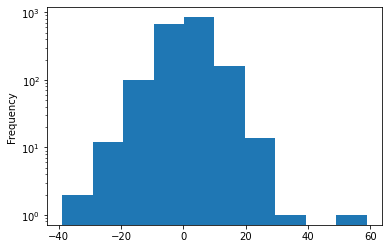

In [30]:
coin_df['pct_change'].plot(kind='hist')
plt.yscale('log')

# somewhat balanced distribution. Luckily skewed + rather than - :-) 


<AxesSubplot:ylabel='Frequency'>

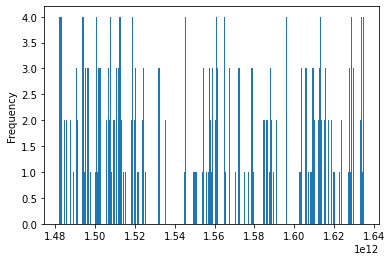

In [40]:
coin_df.loc[coin_df['pct_change'] >= 5]['timestamp'].plot(kind='hist',bins=500) #only 445, and from this histogra, observe peaks in certain areas.


We would have wanted to see this histogram be balanced, instead we see clumps. 

These clumps indicate periods of high return occuring at similar times, and being less frequent in others. 

I used many bins to further partition this dataset, and still shows correlated times. Such is how time series behave!

----

Now let's look into the data extraction. Assuming the candidate selection we've picked is reasonable, now we would like to obtain from our larger df a ton of smaller arrays representing the preceeding week of prices to serve as X, and as y the % change observed on that day. 

In [44]:
# format as follows

# convert to json, each element has key X, the last week of prices, y, the pct_change, and date, the date. 

In [66]:
coin_json = []
window = 7
for i in range(window,coin_df.shape[0]):
    pct_change = coin_df['pct_change'].values[i]
    prices = coin_df['bitcoin_price'].values[i-window:i]
    date = str(coin_df['date'].values[i]).split('T')[0]
    
    coin_json.append({
        'pct_change':pct_change,
        'prices':prices,
        'date':date
    })

In [67]:
coin_json

[{'pct_change': -0.6502079202279442,
  'prices': array([706.0925    , 708.94      , 721.1775    , 713.21414334,
         715.6425    , 703.76      , 702.34631698]),
  'date': '2016-11-13'},
 {'pct_change': 0.2913481178064668,
  'prices': array([708.94      , 721.1775    , 713.21414334, 715.6425    ,
         703.76      , 702.34631698, 705.55      ]),
  'date': '2016-11-14'},
 {'pct_change': 4.2712617246099285,
  'prices': array([721.1775    , 713.21414334, 715.6425    , 703.76      ,
         702.34631698, 705.55      , 712.1588998 ]),
  'date': '2016-11-15'},
 {'pct_change': 3.520301953190999,
  'prices': array([713.21414334, 715.6425    , 703.76      , 702.34631698,
         705.55      , 712.1588998 , 740.89935487]),
  'date': '2016-11-16'},
 {'pct_change': 4.386415123814435,
  'prices': array([715.6425    , 703.76      , 702.34631698, 705.55      ,
         712.1588998 , 740.89935487, 738.48      ]),
  'date': '2016-11-17'},
 {'pct_change': 3.983859240194975,
  'prices': array([70

This serves as the full dataset, next is to truly assign a label, as well as a data split. An idea would be to re-iterate through this json, and add such features. 

In [68]:
for sample in coin_json:
    if sample['pct_change'] >= 3:
        sample['y'] = 1
    else:
        sample['y'] = 0 
        
    

Now for splitting. The obvious thing would be to do so in a sequence, and split on percentages, or simply by year. It's really easy to check what year and assign, so I will do that now. 

In [71]:
for sample in coin_json:
    if sample['date'].split('-')[0] == '2021':
        sample['split'] = 'test'

    if sample['date'].split('-')[0] in ['2019','2020']:
        sample['split'] = 'valid'
    else:
        sample['split'] = 'train'


In [72]:
coin_json

[{'pct_change': -0.6502079202279442,
  'prices': array([706.0925    , 708.94      , 721.1775    , 713.21414334,
         715.6425    , 703.76      , 702.34631698]),
  'date': '2016-11-13',
  'y': 0,
  'split': 'train'},
 {'pct_change': 0.2913481178064668,
  'prices': array([708.94      , 721.1775    , 713.21414334, 715.6425    ,
         703.76      , 702.34631698, 705.55      ]),
  'date': '2016-11-14',
  'y': 0,
  'split': 'train'},
 {'pct_change': 4.2712617246099285,
  'prices': array([721.1775    , 713.21414334, 715.6425    , 703.76      ,
         702.34631698, 705.55      , 712.1588998 ]),
  'date': '2016-11-15',
  'y': 1,
  'split': 'train'},
 {'pct_change': 3.520301953190999,
  'prices': array([713.21414334, 715.6425    , 703.76      , 702.34631698,
         705.55      , 712.1588998 , 740.89935487]),
  'date': '2016-11-16',
  'y': 1,
  'split': 'train'},
 {'pct_change': 4.386415123814435,
  'prices': array([715.6425    , 703.76      , 702.34631698, 705.55      ,
         712.1

Bam. We have our coin json, and although a ton of the assumptions made here will not lead to this model being a good one, nonetheless allows us to get some sort of idea about how this data can be stored and structured, make it easier to build the model and data loaders. 